import sys
import scipy
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import skimage
import skimage.io
from tifffile import imsave
from skimage import morphology, segmentation, measure
from skimage.morphology import disk, watershed, convex_hull_image
from skimage.filter import rank, threshold_otsu, threshold_adaptive #gaussian_filter
from skimage.filter.rank import otsu, autolevel_percentile, enhance_contrast_percentile
from skimage import data
from skimage.filter.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.feature import peak_local_max
from skimage.exposure import adjust_gamma
import numpy as np
import pims
import inspect
import tqdm
import PIL
import math
import cv2
from visualization_utils import TiffStack_corrected

print 'done'

In [1]:
#Load helper functions
import os
import skimage.io
import glob
import tqdm
import csv

import PIL
import cv2
import numpy as np
import scipy.ndimage
import scipy.misc
import math
import skimage
import matplotlib.pyplot as plt
%pylab inline

from IPython.html.widgets import interact
from itertools import compress
from skimage.morphology import disk
from skimage.filters import threshold_otsu
from skimage.filter.rank import entropy

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:727: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now '/home/vburns/.config'/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
#Load data from local directory

#Specify sample characteristics, file ID, and file path
sample_age = 'Human/'
sample_type = '7yo/'
sample_id = ['hJP_7yo_Col4_Tuj_Ins_TestDataset']
directory = '/home/vburns/ClarityOrgans/Pancreas/'

#Specify location to save summary islet data
directory_out = '/home/vburns/ClarityOrgans/Pancreas/Results_Analysis/'

#Optional loop to load more than one sample simultaneously:
#loop through each sample and get actual file path based on name and characteristics
file_path = []
out_path = []
for n in range(len(sample_id)):
    file_path.append(directory+sample_age+sample_type+sample_id[n]+'.oif.files')
    out_path.append(directory_out+sample_id[n])
    
    #Check if the file exists, otherwise print "False" and the path
    print os.path.isdir(file_path[n]), 'for', file_path[n]

True for /home/vburns/ClarityOrgans/Pancreas/Human/7yo/hJP_7yo_Col4_Tuj_Ins_TestDataset.oif.files


In [3]:
# Images were collected in three channels corresponding to autofluorescence, anti-nerve (glial), 
# an anti-insulin (islet)

#Use specific plugin for reading tiff files
skimage.io.use_plugin('tifffile')

#Load the individual three channels
#First, get all the filenames in that channel
for file_dir in file_path: 
    c1_filenames = glob.glob(file_dir + '/s_C001Z*.tif') #channel 1
    c2_filenames = glob.glob(file_dir + '/s_C002Z*.tif') #channel 2
    c3_filenames = glob.glob(file_dir + '/s_C003Z*.tif') #channel 3

#Second, step through each file, and add to an array   
c1_images_stack = []
c2_images_stack = []
c3_images_stack = []
for c1_im_name, c2_im_name, c3_im_name in tqdm.tqdm(zip(c1_filenames, c2_filenames, c3_filenames)): 
    c1_image = PIL.Image.open(c1_im_name)
    c1_images_stack.append(np.array(c1_image))
    c2_image = PIL.Image.open(c2_im_name)
    c2_images_stack.append(np.array(c2_image))
    c3_image = PIL.Image.open(c3_im_name)
    c3_images_stack.append(np.array(c3_image))

#Third, specifically name the channels corresponding to the stain(s) of interst    
glial_images_stack = np.array(c2_images_stack) #anti-nerve, corresponding to channel 2
islet_images_stack = np.array(c3_images_stack) #anti-insulin, correspoding to channel 3

In [4]:
#Often, human datasets are quite large 
#One can optionally downsample each channel

g_stack = []
i_stack = []

#Set degree of downsampling
downsample_parameter = .5

#Apply downsampling to both stacks
for ifile,gfile in tqdm.tqdm(zip(islet_images_stack, glial_images_stack)):
    
    #downsample using bilinear interpolation
    i_stack.append(scipy.misc.imresize(ifile, downsample_parameter, interp='bilinear', mode=None)) 
    g_stack.append(scipy.misc.imresize(gfile, downsample_parameter, interp='bilinear', mode=None))
    
glial_images_stack = np.array(g_stack)
islet_images_stack = np.array(i_stack)

In [5]:
#Rescale images so thresholds are similar
#This is important to normalize variability in microscope settings, staining intensity, 
#and other sources of intensity-based error. Futhermore, it allows the same thresholds to be used in all sample processing

glial_images_stack = (glial_images_stack - glial_images_stack.min()) / float(glial_images_stack.max() - glial_images_stack.min())
glial_images_stack = glial_images_stack * (math.pow(2,16)-1)
glial_images_stack = glial_images_stack.astype(np.uint16)

islet_images_stack = (islet_images_stack - islet_images_stack.min()) / float(islet_images_stack.max() - islet_images_stack.min())
islet_images_stack = islet_images_stack * (math.pow(2,16)-1)
islet_images_stack = islet_images_stack.astype(np.uint16)

In [6]:
#Each sample is maximum intensity projected into 150um sections
num_splits = 8 #8 sections based is based slice thickness, set during data collection on microscope

#Split the image into the correct number of sections and 
#take a maximum intensity projection for each section
#As we only use this for detecting the islets, only the islet-related channel needs to be split
islet_split_max = []
for img_array in tqdm.tqdm(np.array_split(islet_images_stack,num_splits,axis=0)):
    islet_split_max.append(np.amax(img_array, axis=0))
max_project_slices = islet_images_stack.shape[0]/len(islet_split_max)

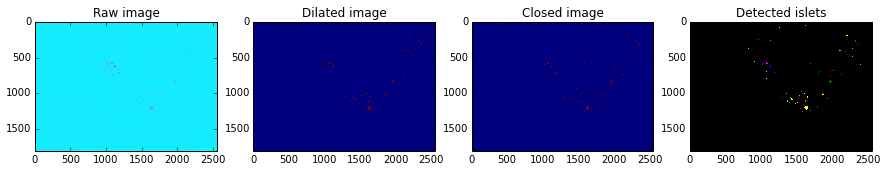

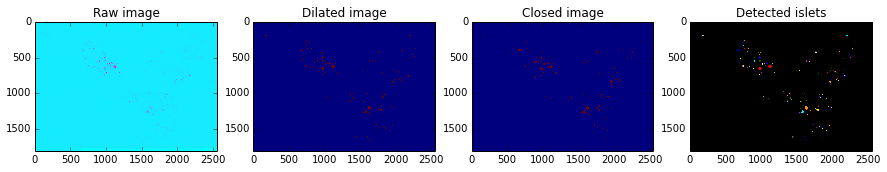

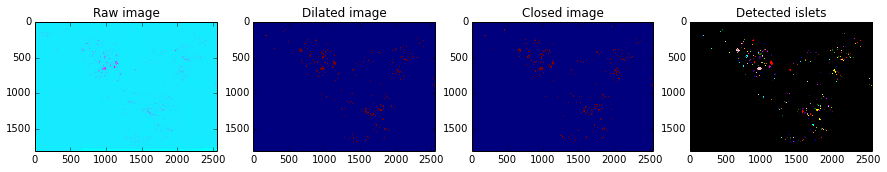

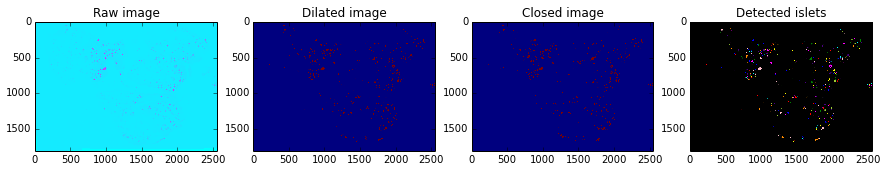

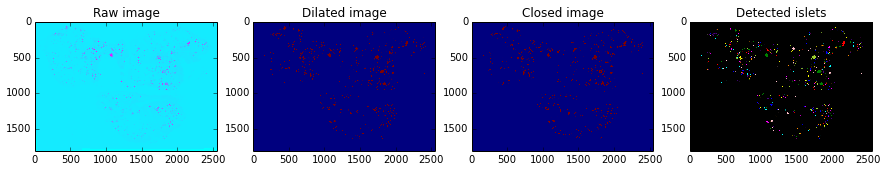

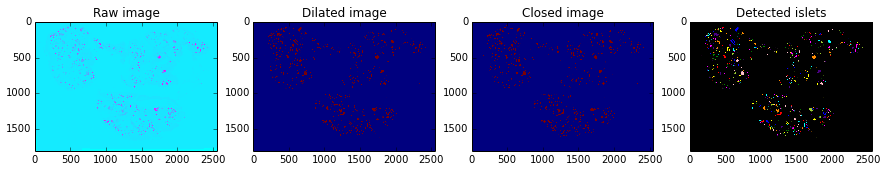

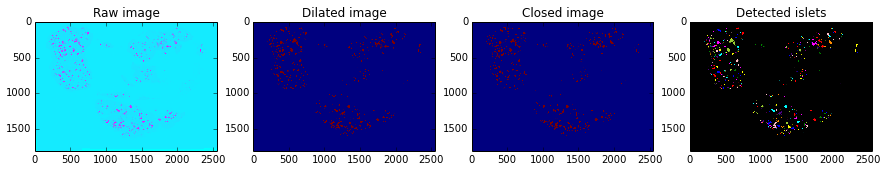

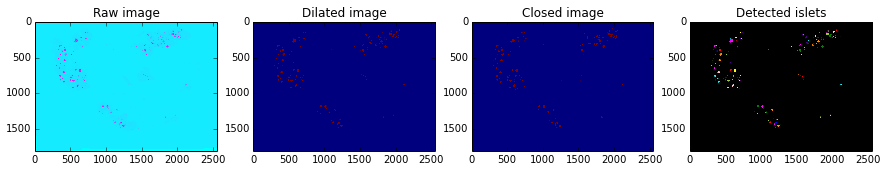

In [15]:
#Create a function to detect islets in each invidual section

#Set parameters based on image and sample quality - should be applied to all processed samples
scaling_factor = .5 #how much to scale the  Otsu's threshold 
closing_disk = disk(1) #set the size of the disk area

def find_regions(img):
    
    #Process images
    gthres = skimage.filters.threshold_otsu(img) * scaling_factor #get Otsu's threshold for the section and scale down 
    img_gthres = img >= gthres 

    img_dil = scipy.ndimage.binary_opening(img_gthres) #perform dilation
    img_closed = skimage.morphology.closing(img_dil, selem=closing_disk) #perform closing
    
    #Perform Euclidean distance transform to get objects
    distance = scipy.ndimage.distance_transform_edt(img_closed) 
    img_markers = scipy.ndimage.label(distance)[0]

    #Measure the region properties of all the detected markers
    roi_props = skimage.measure.regionprops(img_markers, cache=True)

    #Based on the regionprops, exclude any region that has an area of less 
    #than 5 pixels as being noise (too small for an islet)
    bKeep = np.array([(rp['area']>5) for rp in roi_props]).astype(bool)
    region_img = np.zeros_like(img_markers)

    #For each region, apply a unique label to the included regions and remeasure properties of the remaining regions
    for nLabel, rp in enumerate(compress(roi_props,bKeep)):
        region_img[rp['coords'][:,0], rp['coords'][:,1]] = nLabel
    roi_props = skimage.measure.regionprops(region_img)
    label_img = skimage.color.label2rgb(region_img, image=None, colors=None, alpha=1, bg_label=0, bg_color=[0,0,0], image_alpha=.5)
    
    #Optional: Visualize the individual sections to ensure no processing errors
    #This is only a coarse approximation to get islet centers. In the next cell, islet detection is refined
    #using the center coordinates of each marker
    plt.figure(figsize=(15,10))
    subplot(141)
    plt.imshow(img, cmap='cool')
    plt.title('Raw image')
    subplot(142)
    plt.imshow(img_dil)
    plt.title('Dilated image')
    subplot(143)
    plt.imshow(img_closed)
    plt.title('Closed image')
    subplot(144)
    plt.imshow(label_img, cmap = 'cool')
    plt.title('Detected islets')
    
    return region_img, label_img, roi_props

#For each section in the image, detect islets across the whole section
cell_props = []
img_labels = []
for nSlice,image in tqdm.tqdm(enumerate(islet_split_max)):
    region_img, label_img, roi_props = find_regions(image)
    cell_props.append(roi_props)
    img_labels.append(region_img)

In [23]:
#For each detected islet, apply various functions to characterize islet-related parameters.

#Set parameters used for islet detection. Parameters depend on image quality, but once set, 
#are used for all samples
bounding_window=20 #set the size of the bounding box around each islet that will be used to check for encapsulating glia

glial_threshold = 25
beta_threshold=1.5
block_size = 45
constant=12

islet_summary = [] #Array where all islet data is stored

#Go through each section in the image
for slice_num in tqdm.tqdm(range(len(cell_props))):
    
    #Get the slice number at the start and end of section so the relevant nerve-channel slices can be extracted
    start_slice = max_project_slices*slice_num
    end_slice= max_project_slices*(slice_num+1)
    
    #Get the shape of the image in case an islet falls on the border of the image and 
    #a full bounding box cannot be created
    max_rw = glial_images_stack.shape[1]
    max_cl = glial_images_stack.shape[2]

    #Process each detected islet in the section
    lost_islet = 0 #Keep track of islets that are excluded 
    for i in range(len(cell_props[slice_num])):

        #Get the pixel position of the bounding box
        (min_row, min_col, max_row, max_col) = cell_props[slice_num][i]['bbox']
        islet_ypos = (max_row-min_row)/2+min_row
        islet_xpos = (max_col-min_col)/2+min_col

        #Crop the islet and nerve channels into a small bounding box to enhance processing
        islet_crop_max_xy = np.amax(islet_images_stack[start_slice:end_slice,max(min_row-bounding_window,0):min(max_row+bounding_window, max_rw),
                                                       max(min_col-bounding_window,0):min(max_col+bounding_window, max_cl)], axis=0);
        glial_crop_max_xy = np.amax(glial_images_stack[start_slice:end_slice,max(min_row-bounding_window,0):min(max_row+bounding_window, max_rw),
                                                       max(min_col-bounding_window,0):min(max_col+bounding_window, max_cl)], axis=0);

        gthres = threshold_otsu(islet_crop_max_xy) #Get Otsu's threshold for the cropped image
        islet_mask = islet_crop_max_xy>(gthres*.8) #Set a lower islet threshold slightly to detect full islet
        islet_closed = skimage.morphology.closing(islet_mask, selem=disk(1)) #Perform morphological closing

        #Check to make sure only one region is in the bounding box and find region properties.
        #If more than one region is found, proceed with the region tha is closest to the center of the box
        label_img, num_features = scipy.ndimage.label(islet_closed)
        roi_props = skimage.measure.regionprops(label_img, cache=True)
        label_img_x = label_img.shape[0]/2
        label_img_y = label_img.shape[1]/2
        coords_x = []
        coords_y = []
        if len(roi_props) > 1: 
            for rp in roi_props:
                temp_c = rp['centroid']
                coords_x.append(temp_c[0])
                coords_y.append(temp_c[1])

            index = min(range(len(coords_x)), key=lambda i: abs(abs(coords_x[i]-label_img_x)+abs(coords_y[i]-label_img_y)))

            single_roi_props = roi_props[index]
        else: 
            single_roi_props = roi_props[0]

        roi_img = np.zeros_like(label_img)
        roi_img[single_roi_props['coords'][:,0], single_roi_props['coords'][:,1]] = 1
        #Process each region with dilation
        roi_img_dilated = scipy.ndimage.morphology.binary_dilation(roi_img, iterations=1)

        #Determine set of characteristics for that region
        islet_size = sum(roi_img) #sum of pixels in the region
        islet_percentage = islet_size/float(roi_img.shape[0]*roi_img.shape[1]) #percentage of pixels in the box that are classified as islet
        
        #Discard region if region size is less than 5 pixels in area or if
        #the percentage assigned to the islet is more than 70% (this indicates a likely error in thresholding, see supplemental figure)
        if islet_size<5 or islet_percentage>.70:
            print 'Excluding islet based on islet parameters'
        else:
            #Detect nerve-positive pixels
            img_g = glial_crop_max_xy.astype(np.uint16)

            #Scale the image and determine an adaptive threshold. Adaptive is preferable due to variability in stain quality
            eiimg = cv2.convertScaleAbs(img_g, alpha=(255.0/65535.0))
            eiimg[eiimg<glial_threshold]=0
            thresh = cv2.adaptiveThreshold(~eiimg, 255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, 
                                           thresholdType=cv2.THRESH_BINARY_INV, blockSize=block_size, C=constant)
            kernel = np.ones((1,1),np.uint8)

            #Reduce noise by eroding 
            glial_erode = cv2.erode(thresh, kernel, iterations=1)
            glial_erode = glial_erode.astype(np.bool)

            #Set up parameters to determine the size of the inner core of the islet and surrounding neighborhood
            convexhull = skimage.morphology.convex_hull_image(roi_img)
            inner_ring = np.copy(convexhull)
            middle_ring = scipy.ndimage.morphology.binary_erosion(convexhull, iterations=2)
            outer_ring = scipy.ndimage.morphology.binary_dilation(convexhull, iterations=2)
            outer_ring[middle_ring]=0

            #Compute characteristics
            islet_hull = sum(inner_ring) #size of inner core of islet
            num_glial_outer = sum(glial_erode[outer_ring]) #number of nerve positive pixels in neighborhood
            num_glial_middle = sum(glial_erode[middle_ring]) #number of nerve positive pixels on surface
            num_glial_islet = sum(glial_erode[inner_ring]) #number of nerve positive pixels in inner islet core
            glial_ring_area = sum(outer_ring) #the total area in the neighborhood
            glial_center_area = sum(middle_ring) #the total area in the core

            radius = math.sqrt(islet_hull/math.pi) #islet radius
            volume = 4.0/3.0*math.pi*(radius**3) #islet volume
            glial_ihnv = num_glial_islet/volume #percentage of nerve cells in core to islet volume
            glial_onv = num_glial_outer/volume #percentage of nerve cells in neighborhood to islet volume
            glial_inv = num_glial_middle/volume #percentage of nerve cells on surface to islet volume
            glial_ihna = num_glial_islet/float(islet_hull) #percentage of nerve cells in core to islet area
            glial_ona = num_glial_outer/float(islet_hull) #percentage of nerve cells in neighborhood to islet area
            glial_ina = num_glial_middle/float(islet_hull) #percentage of nerve cells on surface to islet area

            #Calculate the entropy of the image to determine if glial threshold is set correctly
            glial_temp = np.copy(glial_erode)
            glial_temp = glial_erode.astype(int)
            per_glial = (sum(glial_temp).astype(float)/(glial_temp.shape[0]*glial_temp.shape[1]))*100
            e_image = glial_temp.astype(np.uint8)
            ent_mean = mean(entropy(e_image, disk(10)))
            ent_median = median(entropy(e_image, disk(10)))

            #If the entropy > .82 or the number of nerve-positive pixels is >32%, exclude. This is likely a thresholding error
            numglialthres=32.0 
            entropythres=0.82 
            if per_glial > numglialthres or ent_mean > entropythres:
                print 'Excluded islet based on nerve parameters'
            else:
                islet_summary.append([slice_num, i, islet_xpos, islet_ypos, islet_size, islet_hull, num_glial_islet, 
                                 glial_ring_area, num_glial_outer, glial_center_area, num_glial_middle,  
                                 radius, volume, glial_ihnv, glial_onv, glial_inv, 
                                 glial_ihna, glial_ona, glial_ina, bounding_window, 
                                 glial_threshold, numglialthres, entropythres, block_size, constant, 
                                 scaling_factor, ent_mean, per_glial])

#Optional: save out data for downstream processing
if True:
    #set file name suffix (will use characteristics from file loading)
    suffix = '_clarity_slice_processed'
    np.savez(out_path[0]+suffix+'.npz', islet_summary=islet_summary)
    out_dir = out_path[0]+suffix+'.csv'
    
    #Write islet characteristics to excel file with clear headers
    fl = open(out_dir, 'w')
    writer = csv.writer(fl)
    writer.writerow(['Slice num', 'Islet num', 'Islet x position', 'Islet y position', 'Islet size', 'Islet hull size', 
                    'Glial in islet hull', 'Outer ring area', 'Glial in outer ring', 'Middle area', 'Glial in middle',
                    'Radius', 'Volume', 'Glial Islet Hull Norm Vol', 'Glial Outer Norm Vol', 'Glial Inner Norm Vol', 
                    'Glial Islet Hull Norm Area', 'Glial Outer Norm Area', 'Glial Inner Norm Area', 'Bounding window', 
                    'glial threshold', 'Num glial threshold', 'Entropy threshold', 'Block size', 'Constant offset', 
                    'Islet scaling factor', 'Entropy', 'Total glial'])
    for values in islet_summary:
        writer.writerow(values)
    fl.close()    

|----------| 0/8   0% [elapsed: 00:00 left: ?, ? iters/sec]Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluded islet based on nerve parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluded islet based on nerve parameters
Excluded islet based on nerve parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluded islet based on nerve parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based on islet parameters
Excluding islet based